## Import

In [35]:
import pandas as pd
import numpy as np

import matplotlib
%matplotlib widget

from pandas.plotting import scatter_matrix

from scipy.stats import mode


import seaborn as sns; 
sns.set_theme()

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

## Preprocessing

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

train_df.head()


Memory usage after optimization is: 259.40 MB
Decreased by 84.8%
Memory usage after optimization is: 63.90 MB
Decreased by 84.8%


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


In [6]:
train_df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,...,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.000000e+06,2.980192e+03,1.515857e+02,1.509754e+01,2.713154e+02,5.166262e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,...,3.746200e-02,3.782075e-02,1.199500e-02,1.605350e-02,1.071275e-02,1.220750e-02,4.075150e-02,3.923925e-02,3.161850e-02,1.771335e+00
std,1.154701e+06,2.890482e+02,1.099611e+02,8.546731e+00,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,...,1.898910e-01,1.907625e-01,1.088629e-01,1.256813e-01,1.029465e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01,8.938060e-01
min,0.000000e+00,1.773000e+03,-3.300000e+01,-3.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,9.999998e+05,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.000000e+06,2.966000e+03,1.230000e+02,1.400000e+01,2.130000e+02,3.100000e+01,1.436000e+03,2.180000e+02,2.240000e+02,1.420000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,2.999999e+06,3.217000e+03,2.470000e+02,2.000000e+01,3.610000e+02,7.800000e+01,2.365000e+03,2.330000e+02,2.370000e+02,1.690000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
max,3.999999e+06,4.383000e+03,4.070000e+02,6.400000e+01,1.602000e+03,6.470000e+02,7.666000e+03,3.010000e+02,2.790000e+02,2.720000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00


In [7]:
train_df.drop(['Id'], axis=1)
test_df.drop(['Id'], axis=1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2763,78,20,377,88,3104,218,213,195,1931,...,0,0,0,0,0,0,0,0,0,0
1,2826,153,11,264,39,295,219,238,148,2557,...,0,0,0,0,0,0,0,0,0,0
2,2948,57,19,56,44,852,202,217,163,1803,...,0,0,1,0,0,0,0,0,0,0
3,2926,119,6,158,134,2136,234,240,142,857,...,0,0,0,0,0,0,0,0,0,0
4,2690,10,4,38,108,3589,213,221,229,431,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2974,254,15,146,100,623,222,245,117,2353,...,0,0,0,0,0,0,0,0,0,0
999996,3180,92,16,93,47,3740,209,201,142,356,...,0,0,0,0,0,0,0,0,1,0
999997,2684,51,20,34,123,962,199,225,145,350,...,0,0,0,0,1,0,0,0,0,0
999998,3309,64,12,196,93,2522,226,193,74,3300,...,0,0,0,0,0,0,0,0,0,0


array([[<AxesSubplot:xlabel='Id', ylabel='Id'>,
        <AxesSubplot:xlabel='Elevation', ylabel='Id'>,
        <AxesSubplot:xlabel='Aspect', ylabel='Id'>,
        <AxesSubplot:xlabel='Slope', ylabel='Id'>,
        <AxesSubplot:xlabel='Horizontal_Distance_To_Hydrology', ylabel='Id'>,
        <AxesSubplot:xlabel='Vertical_Distance_To_Hydrology', ylabel='Id'>,
        <AxesSubplot:xlabel='Horizontal_Distance_To_Roadways', ylabel='Id'>,
        <AxesSubplot:xlabel='Hillshade_9am', ylabel='Id'>,
        <AxesSubplot:xlabel='Hillshade_Noon', ylabel='Id'>,
        <AxesSubplot:xlabel='Hillshade_3pm', ylabel='Id'>],
       [<AxesSubplot:xlabel='Id', ylabel='Elevation'>,
        <AxesSubplot:xlabel='Elevation', ylabel='Elevation'>,
        <AxesSubplot:xlabel='Aspect', ylabel='Elevation'>,
        <AxesSubplot:xlabel='Slope', ylabel='Elevation'>,
        <AxesSubplot:xlabel='Horizontal_Distance_To_Hydrology', ylabel='Elevation'>,
        <AxesSubplot:xlabel='Vertical_Distance_To_Hydrology', yla

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
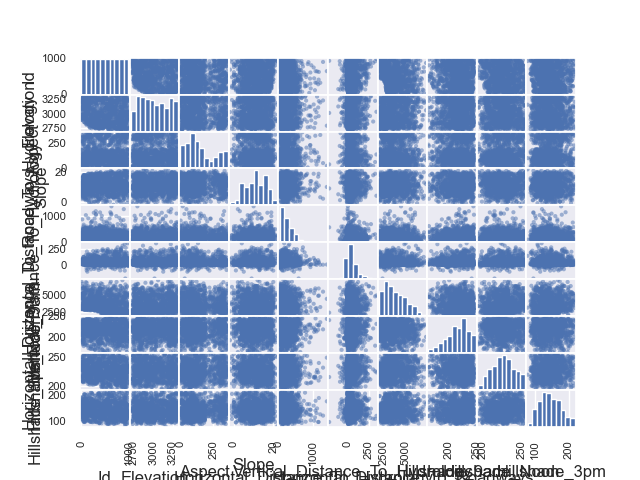

In [18]:
scatter_matrix(train_df.iloc[:1000, :10])

In [12]:
print(train_df.iloc[:, :10].head())

   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   0       3189      40      8                                30   
1   1       3026     182      5                               280   
2   2       3106      13      7                               351   
3   3       3022     276     13                               192   
4   4       2906     186     13                               266   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              13                             3270   
1                              29                             3270   
2                              37                             2914   
3                              16                             3034   
4                              22                             2916   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  
0            206             234            193  
1            233             240            106  
2            2

In [21]:
useful_features = [c for c in train_df.columns if c not in ("Id", "Cover_Type", "kfold")]


df_train = train_df[train_df.Cover_Type!=5]
df_test = test_df[useful_features]

fold = 1
xtrain, xvalid = train_test_split(df_train, test_size=0.2)
xtrain.reset_index(drop=True)
xvalid.reset_index(drop=True)
# xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
# xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)


valid_ids = xvalid.Id.values.tolist()

labels = preprocessing.LabelEncoder().fit(xtrain.Cover_Type)

ytrain = labels.transform(xtrain.Cover_Type)
yvalid = labels.transform(xvalid.Cover_Type)

true_valid = xvalid.Cover_Type

n_class = len(xtrain.Cover_Type.unique())

xtrain = xtrain[useful_features]
xvalid = xvalid[useful_features]


params = {
    'learning_rate': 0.03811822061503613, 
    'reg_lambda': 17.136779266696237, 
    'reg_alpha': 1.196532346754796e-05, 
    'subsample': 0.16103284130404089, 
    'colsample_bytree': 0.9165052246716364, 
    'max_depth': 10,
    'grow_policy': 'depthwise'
}

model = XGBClassifier(
    
    random_state = 42,
    tree_method='gpu_hist',
    objective = 'multi:softmax',
    sampling_method = 'gradient_based',
    n_estimators=10000,
    n_jobs=-1,
    num_class = n_class,
    use_label_encoder=False,
    eval_metric = 'mlogloss',
    **params
)

In [22]:

model.fit(xtrain, ytrain,early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=1000)

[0]	validation_0-mlogloss:1.71818
[1000]	validation_0-mlogloss:0.08185
[2000]	validation_0-mlogloss:0.08077
[2196]	validation_0-mlogloss:0.08083


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9165052246716364,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03811822061503613,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10000, n_jobs=-1,
              num_class=6, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42,
              reg_alpha=1.196532346754796e-05, reg_lambda=17.136779266696237,
              sampling_method='gradient_based', scale_pos_weight=None,
              subsample=0.16103284130404089, ...)

In [23]:

xtest = df_test.copy()

preds_valid = labels.inverse_transform(model.predict(xvalid))
test_preds = labels.inverse_transform(model.predict(xtest))

print(accuracy_score(true_valid, preds_valid))

0.96151125


In [57]:

submission_df = pd.read_csv("data/sample_submission.csv")

test_ids = test_df.Id.values.tolist()
print(len(test_preds))
print(len(test_ids))
submission_df = pd.DataFrame(list(zip(test_ids, test_preds)), columns=["Id", "Cover_Type"])

# print(test_preds)
# submission_df.Cover_Type = mode(np.column_stack({}.update(dict(zip(valid_ids, preds_valid)))), axis=1)[0]
# print(np.column_stack(dict(zip(valid_ids, preds_valid)).items()))
#model(np.column_stack(final_test_predictions), axis=1)[0]
submission_df.columns = ["Id", "Cover_Type"]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

1000000
1000000


,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


In [24]:
model.save_model("xgboost.json")